Test

In [1]:
import numpy as np

assert np.array([1,2,3])@np.array([1,2,3]) == 14, 'Math is not mathing'

In [2]:
print("hallo wereld")

hallo wereld


In [4]:
from mesa import Agent
from mesa import Model

c:\Users\Alvin\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#Tutorial mesa:
#   https://mesa.readthedocs.io/stable/tutorials/intro_tutorial.html

# Onderstaande is niet echt een goed model. Is meer gebruikt om Mesa te leren begrijpen en te kijken wat mogelijk is. 
# House_Model is beter, aangezien het een meer afgebakend onderwerp is en meer een agent based model is (Gebruikt verschillende agents die interactie hebben met elkaar)

class FED_Agent(Agent):
    """Agent that models the FED (Central bank of US)"""

    def __init__(self, model):
        super().__init__(model)
        self.interest_rate = 4.75 #current

    #test print uit tutorial
    def print_func(self):
        print(f"The interest rate = {str(self.interest_rate)}. ID = {str(self.unique_id)}.")

class Bank_Agent(Agent):
    """Agent that models the banks"""
    def __init__(self, model):
        super().__init__(model)
        self.money_in_banks = 100 #in trillions oid.
        self.profit_precentage = 0 

    def print_money_in_bank(self):
        print(f"Money in Bank is: {self.money_in_banks}")

    def print_profits(self):
        print(f"Profit is: {self.profit_precentage}")

    def change_profits(self, num):
        self.profit_precentage = num

class Energy_Sector_Agent(Agent):
    """Agent that models the energy sector"""
    def __init__(self, model):
        super().__init__(model)
        self.change_in_energy_price = 0

class Real_Estat_Agent(Agent):
    def __init__(self, model, avarege_cost_house = 250000, mortage_rate = 4.75, new_houses = 0, house_buyers = 100):
        super().__init__(model)
        self.avarege_cost_house = avarege_cost_house
        self.mortage_rate = mortage_rate
        self.avarege_cost_mortage = mortage_rate / 100 * avarege_cost_house
        self.new_houses = new_houses
        self.house_buyers = house_buyers

    def print_cost_house(self):
        print(f"cost of house = {self.avarege_cost_house}")

    def step(self, interest_rate):
        #zet stap door alleen te kijken naar interest rate en op basis daarvan hoeveelheid nieuwe huizen gebouwd.
        if interest_rate <= 0:
            self.new_houses = 110 #interest rate van 0 -> goedkoop lenen, dus huizen bouwen met geleend geld is goedkoper dus meer huizen gebouwd dan vraag naar huizen is.
        else:
            self.new_houses = 110 - (interest_rate * 3) # higher interest rate = more costs lending = more costs houses = less houses build
            #interest rate * 3 is op weinig gebasseerd
        shortage_houses = int(self.house_buyers - self.new_houses)
        self.avarege_cost_house += 100 * shortage_houses

        
class Model1(Model):
    """Model for attempt 1."""

    def __init__(self, n, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n

        FED_Agent.create_agents(model = self, n = 1)
        Bank_Agent.create_agents(model = self, n = 1)
        Energy_Sector_Agent.create_agents(model = self, n = 1)
        Real_Estat_Agent.create_agents(model = self, n = 1)

    def house_market_step(self):
        #ga 1 stap verder in model voor alleen house market

        REA = self.agents.select(agent_type = Real_Estat_Agent)
        REA.do("step", 3)
        REA.do("print_cost_house")

        #voor pakken interest rate uit FED

        #FED = self.agents.select(agent_type = FED_Agent)
        #REA.do("step", FED.get("interest_rate")[0])
        #REA.do("print_cost_house")
    
    
    def printing(self):

        #printen profits van banken met verandering in bank door actie change profits
        bank = self.agents.select(agent_type = Bank_Agent)
        fed = self.agents.select(agent_type = FED_Agent)
        print(bank.get("profit_precentage"))
        bank.do("change_profits", fed.get("interest_rate")[0] / 3)
        bank.do("print_profits")

        #printen van alle parameters
        for a in self.agents:
            keys = list(a.__dict__.keys())
            keys = [keys[i] for i in range(len(keys)) if i >=3]
            for key in keys:
                print(key, '=', a.__dict__[key])

In [6]:
#running model
starter_model = Model1(10)
# printen van alle parameters
for _ in range(1):
    starter_model.printing()

[0]
Profit is: 1.5833333333333333
interest_rate = 4.75
money_in_banks = 100
profit_precentage = 1.5833333333333333
change_in_energy_price = 0
avarege_cost_house = 250000
mortage_rate = 4.75
avarege_cost_mortage = 11875.0
new_houses = 0
house_buyers = 100


In [7]:
#10 stappen in house market en printen van kosten van een gemiddeld huis.
for _ in range(10):
    starter_model.house_market_step()

cost of house = 249900
cost of house = 249800
cost of house = 249700
cost of house = 249600
cost of house = 249500
cost of house = 249400
cost of house = 249300
cost of house = 249200
cost of house = 249100
cost of house = 249000


In [8]:
from mesa import DataCollector

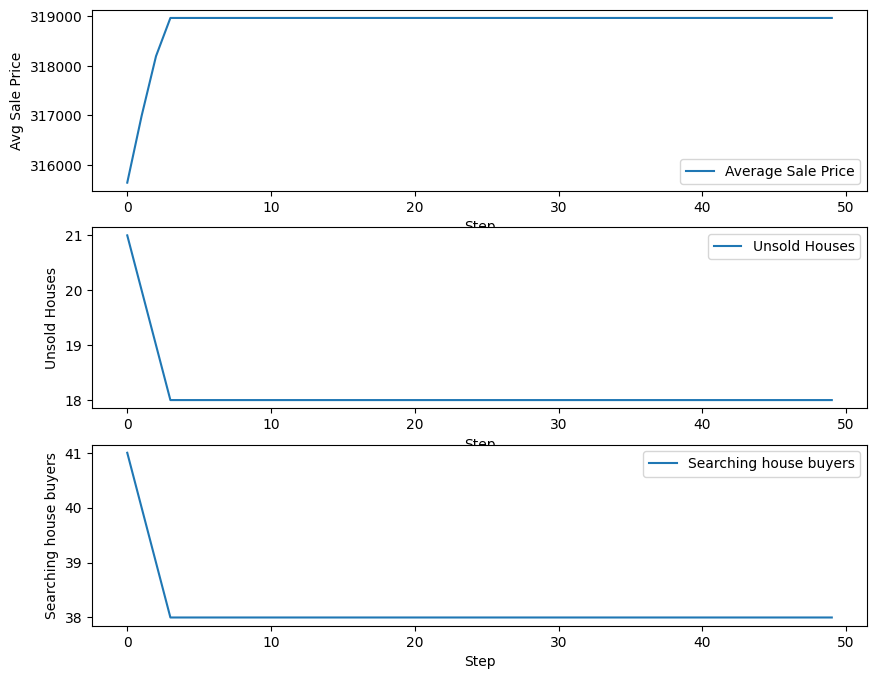

In [ ]:
#poging 2 -> is meer een echt agent based model

#update plan:
#Elke beurt toevoegen:
#   Kleine hoeveelheid nieuwe kopers, die per beurt constant is. -> Kan evt gebasseeerd worden op groei US bevolking en dan een verhouding pakken.
#   Kleine hoeveelheid nieuwe huizen, die afhankelijk is van interest rates. Hogere interest rates -> lenen duurder -> minder huizen. 
import matplotlib.pyplot as plt
import numpy as np
from mesa import Agent, Model
from mesa.datacollection import DataCollector

class BuyerAgent(Agent):
    def __init__(self, model, interest_rate):
        super().__init__(model)
        # interest rates zorgen ervoo dat financieren huis moeilijker wordt dus gaat budget omlaag op basis van interest rate
        self.budget = int(np.random.randint(100000, 600000) * (1 - interest_rate / 100))
        self.house_bought = False

    def find_seller(self, model):
        if self.house_bought == False:
            sellers = [agent for agent in model.agents if isinstance(agent, SellerAgent) and not agent.house_sold]
            affordable_sellers = [seller for seller in sellers if seller.cost <= self.budget]
            if affordable_sellers:
                chosen_seller = self.random.choice(affordable_sellers)
                self.house_bought = True
                chosen_seller.house_sold = True
                model.sales.append(chosen_seller.cost)


class SellerAgent(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.cost = np.random.randint(100000, 600000)
        self.orig_cost = self.cost
        self.house_sold = False

    def lower_cost(self):
        #Als huis niet verkocht wordt, wordt de prijs verlaagt. Gebeurt tot een waarde van 80 % van orginele kosten.
        if self.house_sold == False and self.cost >= self.orig_cost * 0.8:
            self.cost = self.cost * 0.9
    

class House_Model(Model):
    def __init__(self, number_of_buyers, number_of_sellers, seed=None, interest_rate=4.75):
        super().__init__(seed=seed)
        self.num_buyers = number_of_buyers
        self.num_sellers = number_of_sellers
        self.interest_rate = interest_rate
        
        BuyerAgent.create_agents(self, self.num_buyers, self.interest_rate)
        SellerAgent.create_agents(self, self.num_sellers)

        # Data collector
        self.datacollector = DataCollector(
            model_reporters={
                "Average Sale Price": self.compute_avg_sale_price,
                "Unsold Houses": self.compute_unsold_inventory,
                "Searching house buyers": self.compute_num_house_buyers,
            },
        )

        self.sales = []

    def step(self):
        self.agents.select(agent_type = BuyerAgent).shuffle_do("find_seller", self)
        self.lower_prices_not_sold()
        self.datacollector.collect(self)
    
    def lower_prices_not_sold(self):
        sellers = [agent for agent in self.agents if isinstance(agent, SellerAgent) and not agent.house_sold]
        for seller in sellers:
            seller.lower_cost()

    def compute_avg_sale_price(self):
        if self.sales:
            return np.mean(self.sales)  
        else:
            return 0

    def compute_unsold_inventory(self):
        sellers = [agent for agent in self.agents if isinstance(agent, SellerAgent)]
        return sum(1 for seller in sellers if not seller.house_sold)

    def compute_num_house_buyers(self):
        buyers = [agent for agent in self.agents if isinstance(agent, BuyerAgent)]
        return sum(1 for buyer in buyers if not buyer.house_bought)



model = House_Model(number_of_buyers=100, number_of_sellers=80, interest_rate=4.0)

for i in range(50):
    model.step()

results = model.datacollector.get_model_vars_dataframe()
# print(results)

plt.figure(figsize=(10, 8))

plt.subplot(311)
plt.plot(results['Average Sale Price'], label='Average Sale Price')
plt.xlabel('Step')
plt.ylabel('Avg Sale Price')
plt.legend()

plt.subplot(312)
plt.plot(results['Unsold Houses'], label='Unsold Houses')
plt.xlabel('Step')
plt.ylabel('Unsold Houses')
plt.legend()

plt.subplot(313)
plt.plot(results['Searching house buyers'], label='Searching house buyers')
plt.xlabel('Step')
plt.ylabel('Searching house buyers')
plt.legend()

plt.show()
